# **Sentiment Analysis for Product Review**

**IMPORTING RELEVANT LIBRARIES**

In [1]:
%pip install wordcloud imbalanced-learn
%pip install -U imbalanced-learn
%pip install -U scikit-learn
%pip install -U seaborn
%pip install -U matplotlib
%pip install nltk
%pip install -U pandas
%pip install -U numpy
%pip install -U matplotlib
%pip install -U wordcloud
%pip install -U tqdm
%pip install -U pyspellchecker

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import re # Regular expressions
import nltk
from nltk.corpus import stopwords # Stop words removal
from nltk.tokenize import word_tokenize # Word tokenization
from nltk.stem import WordNetLemmatizer  # Word lemmatization
# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF vectorization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample, shuffle
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

[nltk_data] Downloading package punkt to C:\Users\Taqi
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Taqi
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Taqi
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Taqi
[nltk_data]     Haider\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Loading the dataset
data = pd.read_csv("ReviewsDataset.csv")


In [4]:
# Checking the shape
data.shape

(568454, 10)

In [5]:
#Checking the Cloumns
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
# Previewing the dataset
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
# Checking the Scores/Ratings Distribution
data.Score.value_counts()

Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

In [8]:
# Checking for Missing Values
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [9]:
# Dropping the Rows with Missing Values
data.dropna(inplace=True)

In [10]:
# Checking the shape again
data.shape

(568401, 10)

In [11]:
# Removing the unnecessary features and retaining the relevant features for Sentiment Analysis
data = data[['Score','Summary','Text']]

In [12]:
# Previewing the dataset again
data.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
# Making the copy of the dataset
df = data.copy()

In [14]:
# Concatenating the Summary and Text features
df['Review'] = df['Summary'] + " " + df['Text']
df = df.drop(['Summary','Text'],axis=1)
df.head()

,Score,Review
0,5,Good Quality Dog Food I have bought several of...
1,1,Not as Advertised Product arrived labeled as J...
2,4,"""Delight"" says it all This is a confection tha..."
3,2,Cough Medicine If you are looking for the secr...
4,5,Great taffy Great taffy at a great price. The...


In [15]:
# Cleaning the Dataset

def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    text = text.lower() # Convert to lowercase
    return text

df['Review'] = df['Review'].apply(clean_text)
df.head()

,Score,Review
0,5,good quality dog food i have bought several of...
1,1,not as advertised product arrived labeled as j...
2,4,delight says it all this is a confection that ...
3,2,cough medicine if you are looking for the secr...
4,5,great taffy great taffy at a great price ther...


In [16]:
# Initializing the stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Defining a function to preprocess the text
def preprocess_text(review):
    # Tokenization
    tokens = word_tokenize(review)

    # Stopword Removal
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

     # Join the tokens back into a string
    cleaned_review = ' '.join(lemmatized_tokens)

    return cleaned_review

# Applying the function to the Review column
df['cleaned_review'] = df['Review'].apply(preprocess_text)

df = df.drop(['Review'], axis=1)

In [17]:
# Previewing the data
df.head()

,Score,cleaned_review
0,5,good quality dog food bought several vitality ...
1,1,advertised product arrived labeled jumbo salte...
2,4,delight say confection around century light pi...
3,2,cough medicine looking secret ingredient robit...
4,5,great taffy great taffy great price wide assor...


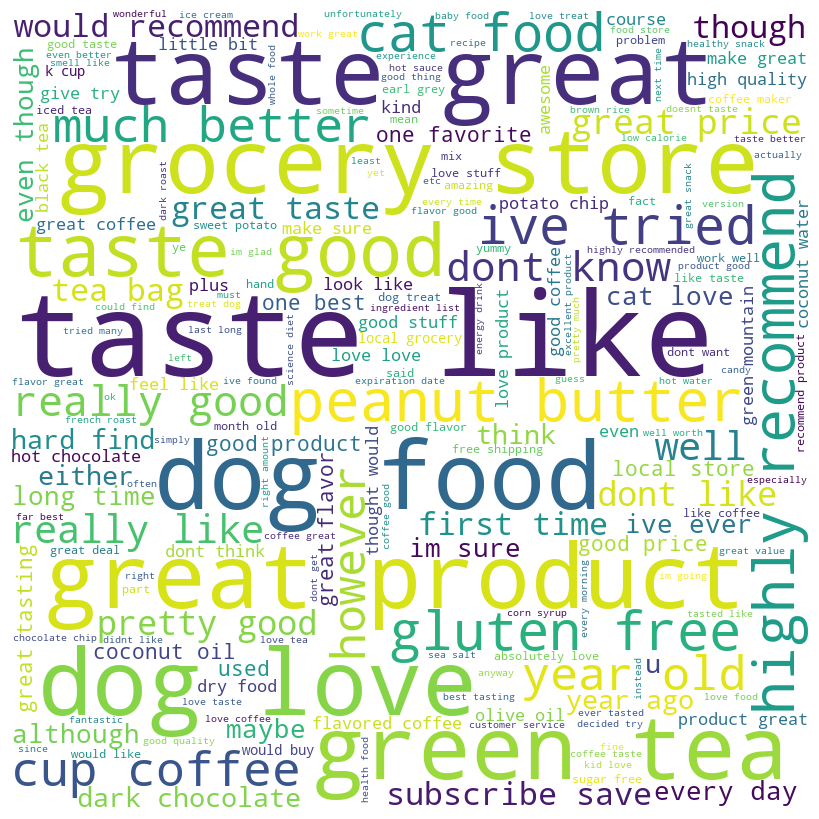

In [18]:
# Combining all cleaned reviews into a single string
text = ' '.join(df['cleaned_review'].astype(str).tolist())

# Creating a WordCloud object
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words, # Use the stop words you defined earlier
                min_font_size = 10).generate(text)

# Plotting the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [19]:
# Defining sentiment labels based on the rating
def get_sentiment(rating):
    if rating < 3.0:
        return 'negative'
    elif rating >= 4.0:
        return 'positive'
    else:
        return 'neutral'

# Applying the function to create a new sentiment column
df['sentiment'] = df['Score'].apply(get_sentiment)

# Dropping the rating column as it has served its purpose
df = df.drop(['Score'], axis=1)

df.head()

,cleaned_review,sentiment
0,good quality dog food bought several vitality ...,positive
1,advertised product arrived labeled jumbo salte...,negative
2,delight say confection around century light pi...,positive
3,cough medicine looking secret ingredient robit...,negative
4,great taffy great taffy great price wide assor...,positive


sentiment
positive    443756
negative     82007
neutral      42638
Name: count, dtype: int64


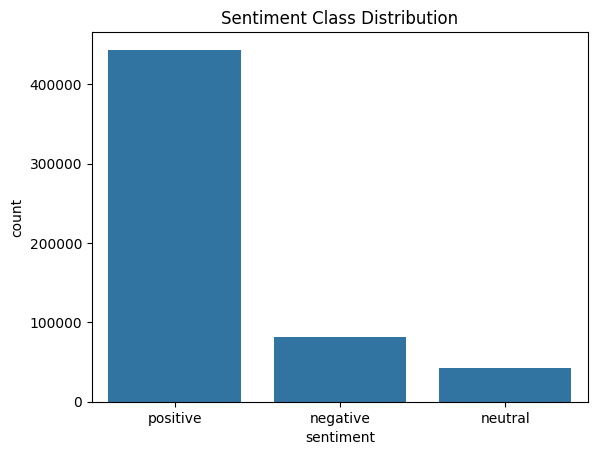

In [20]:
# Checking for class distribution
print(df['sentiment'].value_counts())

# Visualize the distribution
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Class Distribution')
plt.show()

In [21]:
# Encode the sentiment labels using LabelEncoder
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
df.head()

,cleaned_review,sentiment
0,good quality dog food bought several vitality ...,2
1,advertised product arrived labeled jumbo salte...,0
2,delight say confection around century light pi...,2
3,cough medicine looking secret ingredient robit...,0
4,great taffy great taffy great price wide assor...,2


In [22]:
# Separate the classes
positive_reviews = df[df['sentiment'] == 2]
neutral_reviews = df[df['sentiment'] == 1]
negative_reviews = df[df['sentiment'] == 0]

# Downsample positive reviews
positive_reviews_downsampled = resample(positive_reviews,
                                        replace=False,     # sample without replacement
                                        n_samples=85000,   # match the negative sample size
                                        random_state=42)   # for reproducibility

# Combine downsampled positives with original neutral and negative
balanced_df = pd.concat([positive_reviews_downsampled, neutral_reviews, negative_reviews])

In [23]:
balanced_df.shape

(209645, 2)

sentiment
2    85000
0    82007
1    42638
Name: count, dtype: int64


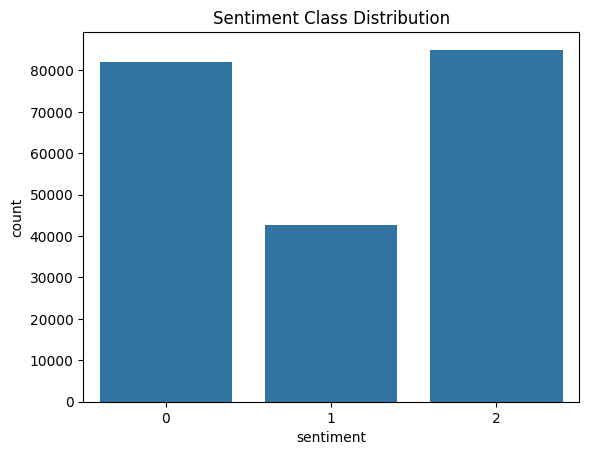

In [24]:
print(balanced_df.value_counts('sentiment'))

# Visualize the distribution
sns.countplot(x='sentiment', data=balanced_df)
plt.title('Sentiment Class Distribution')
plt.show()

In [25]:
# Shuffling the data
balanced_df = shuffle(balanced_df, random_state=42)

In [26]:
# Splitting the dataset into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(balanced_df['cleaned_review'], balanced_df['sentiment'], stratify=balanced_df['sentiment'], train_size=0.8 , test_size=0.2, random_state=42)

In [27]:
#TF-IDF Vectorization
vect = TfidfVectorizer(max_features=7500, ngram_range=(1, 2), max_df=0.85, min_df=2)
X_train_vectorized = vect.fit_transform(X_train)  # Fit on training data
X_test_vectorized = vect.transform(X_test)        # Transform test data with the same vectorizer


In [28]:
import pickle
# Save the vectorized datasets to a file using pickle
with open('vectorized_data.pkl', 'wb') as file:
    pickle.dump(vect, file)


In [29]:
# Checking the Vocabulary Size
vocab_size = len(vect.vocabulary_)
print("Vocabulary size:", vocab_size)

Vocabulary size: 7500


In [30]:
#SMOTE Upsampling on Training Data
smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vectorized, y_train)

# LOGISTIC REGRESSION

In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

best_params = grid_search.best_params_

best_model = grid_search.best_estimator_

NameError: name 'LogisticRegression' is not defined

In [ ]:
print("Best Hyperparameters:", best_params)
print(best_model)

Best Hyperparameters: {'C': 10, 'penalty': 'l2'}
LogisticRegression(C=10)


In [ ]:
# Initialize the logistic regression model with L2 regularization (default for 'penalty' is 'l2')
log_reg_model = LogisticRegression(penalty='l2', C=10, solver='lbfgs', max_iter=1000, random_state=42)

# Train the model on the vectorized training data
log_reg_model.fit(X_train_balanced, y_train_balanced)


LogisticRegression(C=10, max_iter=1000, random_state=42)

In [ ]:
# Predict on the vectorized test set
y_pred = log_reg_model.predict(X_test_vectorized)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

NameError: name 'log_reg_model' is not defined

In [ ]:
with open('log_reg_model.pkl', 'wb') as file:
    pickle.dump(log_reg_model, file)

# SVM(SUPPORT VECTOR MACHINE

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_balanced, y_train_balanced)

In [ ]:
y_pred = svm_model.predict(X_test_vectorized)

In [ ]:
svm_accuracy = accuracy_score(y_test, y_pred)
print("SVM Model Accuracy:", svm_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

SVM Model Accuracy: 0.7884757566362184

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82     16401
           1       0.55      0.70      0.62      8528
           2       0.90      0.83      0.86     17000

    accuracy                           0.79     41929
   macro avg       0.76      0.77      0.77     41929
weighted avg       0.81      0.79      0.79     41929



In [ ]:
with open('SVM.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

# DATAFRAME VISUALIZATION (ACCURACY AND LOSS)

In [ ]:
data = {
    'Model': ['Logistic Regression', 'SVM'],
    'Accuracy': [0.7899, 0.7884],
    'Loss':[1-0.7899, 1-0.7884]
}
df = pd.DataFrame(data)

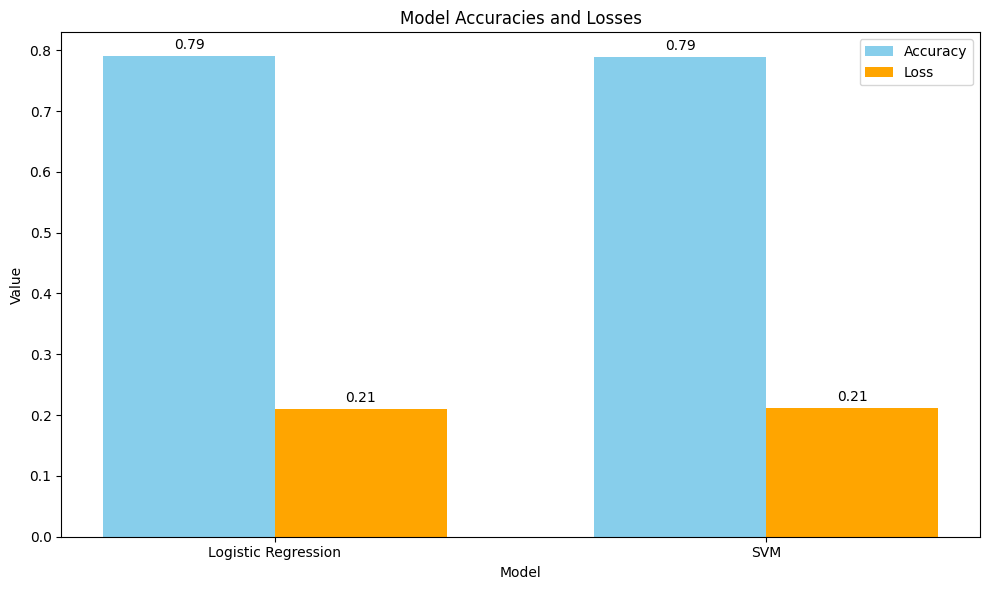

In [ ]:
# Create a grouped bar chart
x = np.arange(len(df['Model']))  # Position of groups on the x-axis
width = 0.35  # Width of the bars

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for Accuracy and Loss
accuracy_bars = ax.bar(x - width/2, df['Accuracy'], width, label='Accuracy', color='skyblue')
loss_bars = ax.bar(x + width/2, df['Loss'], width, label='Loss', color='orange')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Value')
ax.set_title('Model Accuracies and Losses')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'])
ax.legend()

# Add value annotations on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Text to display
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Position
                    xytext=(0, 3),  # Offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(accuracy_bars)
add_labels(loss_bars)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

metrics_dict = {
    'Model': ['Logistic Regression', 'SVM'],
    'Accuracy': ['79%', '79%'],
    'Precision': ['80%', '80%'],
    'Recall': ['79%', '79%'],
    'F1-Score': ['79%', '79%'],
    'TrainingTime (mins)': [25, 723]
}

metrics_df = pd.DataFrame(metrics_dict)
metrics_df


,Model,Accuracy,Precision,Recall,F1-Score,TrainingTime (mins)
0,Logistic Regression,79%,80%,79%,79%,25
1,SVM,79%,80%,79%,79%,723
